# Compare Gaussian fits across all flights

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site
from astropy.modeling.models import AiryDisk2D

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [2]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice_xy(xes,yes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col


def Gauss_2D_fromgrid(beam,concat,find,chind):
    xes = np.ndarray.flatten(beam.x_centers_grid[:,:,0])
    yes = np.ndarray.flatten(beam.y_centers_grid[:,:,0])
    Gfit = np.zeros(beam.V_LC_operation[:,:,0,0].shape)
    P = [1.0,0.0,concat.G_popt[chind,find,2],0.0,
        concat.G_popt[chind,find,4],concat.G_popt[chind,find,5]]
    #fits = fu.Gauss_2d_LC_func(concat.G_popt[chind,find,:-1],xes,yes)
    fits = fu.Gauss_2d_LC_func(P,xes,yes)
    reshapefits = fits.reshape((beam.x_centers_grid[:,:,0].shape))
    return reshapefits

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

['Averaged_2dGauss_and_Airy_Param.npz' 'Coadded_2dGauss_With_Errors.npz'
 'Coadded_2dGauss_and_Airy_Params.npz'
 'Coadded_2dGauss_and_Airy_Params_18mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_20mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_25mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_halfspace.npz'
 'FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Air

In [59]:
## Plan: ##
# 1. Read in flight 618 (N pol flight)
# 2. divide N pols by corresponding Gaussian fits
# 3. read in Gauss fits for flight 620 (Epol flight)
# 4. divide E pols by flight 620 Gauss fits
# 5. Read in 620 flight
# 6. divide E pols by 620 fits
# 7. overplot E-pol copol (flight 620) and Epol cross pol (flight 618)
# 8. divide N pols in 620 with Gaussian fits for 618
# 9. overplot N pol copol (flight 618) and Npol cross pol (flight 620)

In [60]:
find = 900

In [61]:
# Read in Flight 618
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
t_cut_618=concattest618.inds_on    

fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest620=pickle.load(pfile)
t_cut_620=concattest620.inds_on    

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/F

In [62]:
## Read in Gaussian fit params:

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits618 = np.load(ffile)
gp_618 = fits618['G_popt'][:,:,0] # amplitude

print(gp_618)

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits620 = np.load(ffile)
gp_620 = fits620['G_popt'][:,:,0] # amplitude

print(gp_620)

[[            nan  8.27211605e-12  6.89110476e-11 ...  2.29385826e-10
   1.70989551e-10  1.72966023e-10]
 [ 7.69190623e-09  4.68022185e-10  5.01520193e-10 ...  1.20225054e-09
   1.15547178e-09  1.14375053e-09]
 [ 2.14370666e-09  1.01065056e-10  9.97352788e-11 ...  1.47387849e-10
   1.50466146e-10  1.86117403e-10]
 ...
 [            nan             nan             nan ...             nan
              nan             nan]
 [-4.37491042e-12  1.45554688e-11  1.54651856e-11 ...  8.47825872e-11
   3.97238631e-11  5.87279926e-11]
 [ 7.38117269e-09  1.01023818e-08  1.01558622e-08 ...  2.94635351e-09
   2.92100225e-09  2.89325052e-09]]
[[0.00000000e+00 1.92088397e-09 1.91744152e-09 ... 9.18669654e-10
  8.90883343e-10 8.60546737e-10]
 [3.42757136e-09 2.47656520e-11 2.56595453e-11 ... 1.72699237e-10
  1.02652108e-10 1.69623246e-10]
 [7.41549539e-09 4.66853108e-09 4.74172558e-09 ... 2.20807405e-09
  2.18513077e-09 2.21131345e-09]
 ...
 [0.00000000e+00            nan            nan ...            

[ 4.00790850e-08 -2.89226419e+00  9.75446814e+00  1.38050836e+00
  9.17008723e+00  4.06120265e-10  0.00000000e+00]


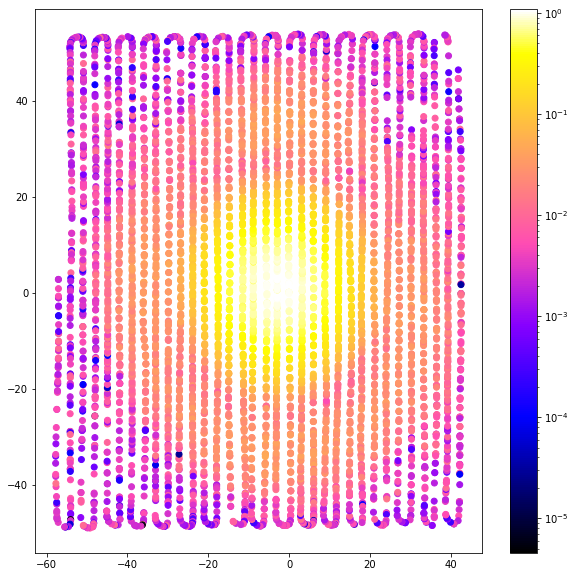

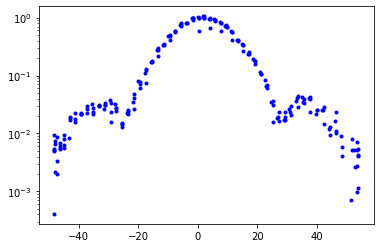

In [63]:
## Let's start by checking regular co-pol normalization - N pol: 

chind=1
print(concattest618.G_popt[chind,find,:])

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]


# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()


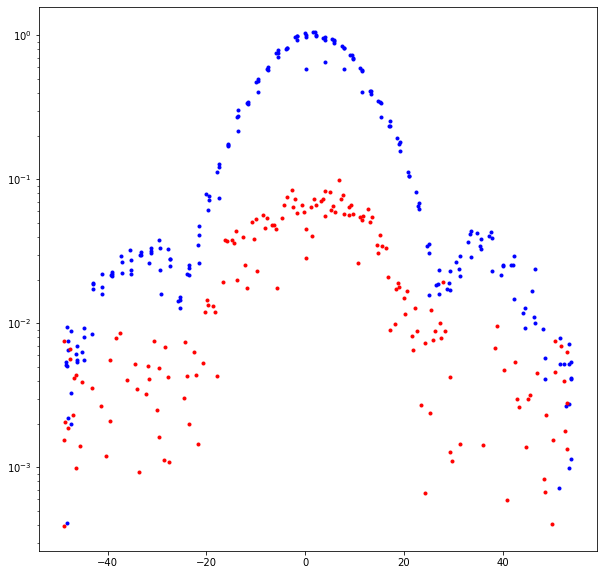

In [64]:
## Now let's plot slices together - N pol


# Flight 618, N pol (1 is a good input)
chind=1

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice

plt.figure(1,figsize=(10,10))
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')

## Let's look at that same channel, in cross-pol flight, divide by same value:

x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]


# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')
plt.show()

3.295653731499684e-08


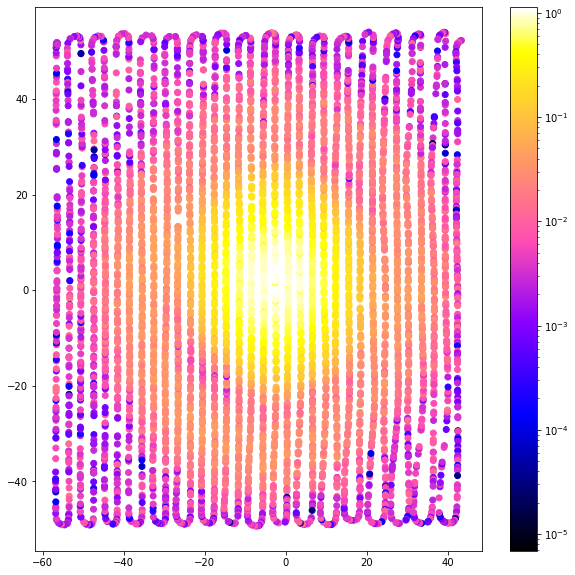

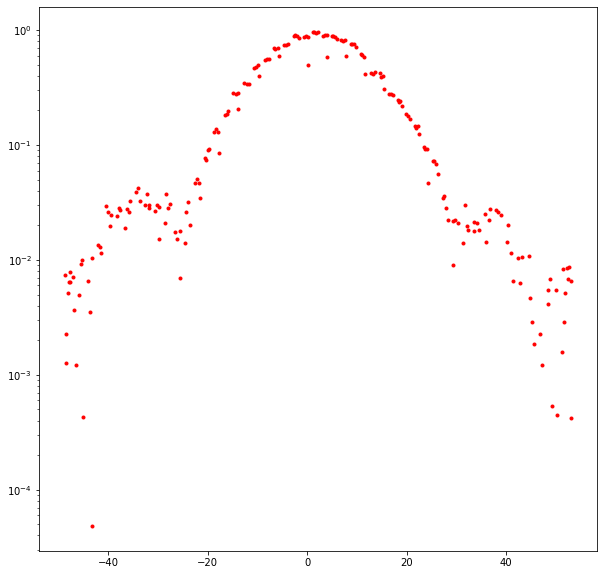

In [65]:
# Repeat for E pol

chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')



3.295653731499684e-08


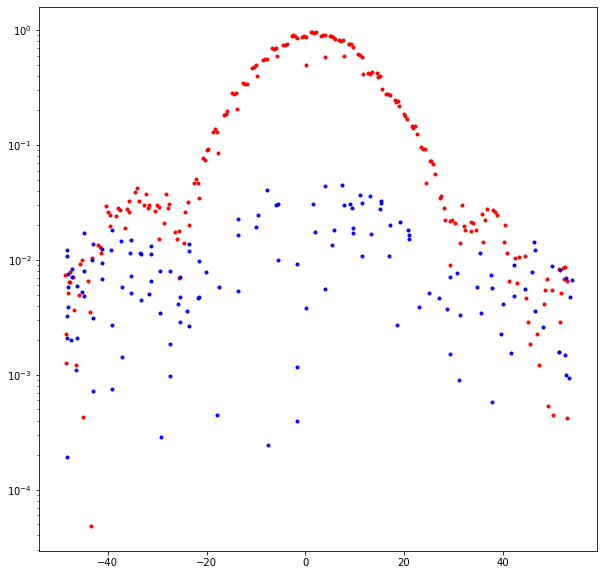

In [66]:
# Now reverse - plot slices together, E pol

# Flight 620, E pol (0 is a good input)
chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])


# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')

# Flight 618, N pol (1 is a good input)
x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()



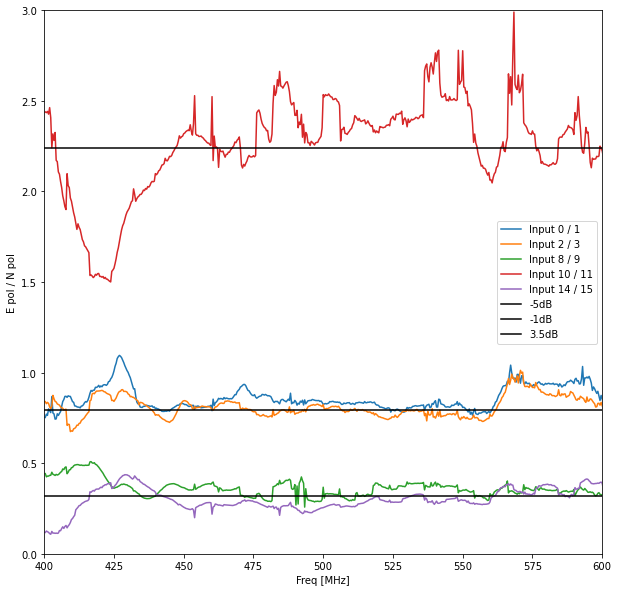

In [89]:
# check the ratio of gains between X and Y pols, to compare to 360 rotations
plt.figure(1,figsize=(10,10))
for chind in pols:
    plt.plot(freqs,gp_620[chind,:]/gp_618[chind+1,:],label='Input '+str(chind)+' / '+str(chind+1))
plt.xlim(400,600)
plt.ylim(0,3)
plt.axhline(10**(-5.0/10.),label='-5dB',color='black')
plt.axhline(10**(-1/10.),label='-1dB',color='black')
plt.axhline(10**(3.5/10.),label='3.5dB',color='black')
plt.ylabel('E pol / N pol')
plt.xlabel('Freq [MHz]')
plt.legend()
plt.show()

[0, 2, 8, 10, 14]


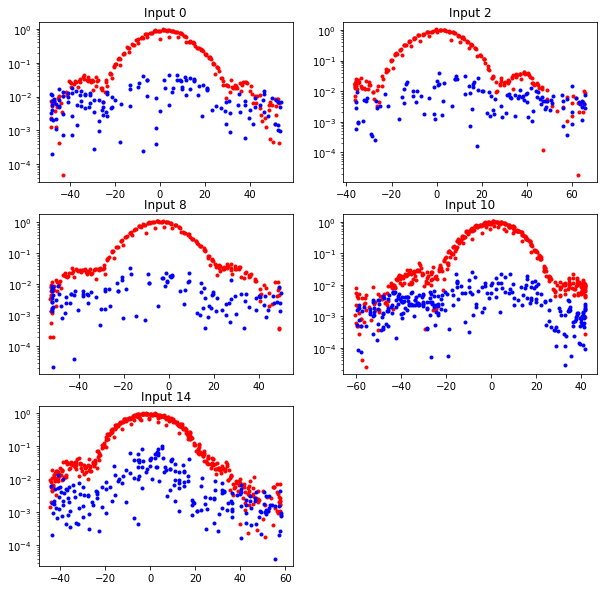

In [71]:
# Now let's try to do this for all pols

print(pols)

# E pols 

# Flight 620, E pol (0 is a good input)
plt.figure(1,figsize=(10,10))
for cc, chind in enumerate(E_pols):
    plt.subplot(3,2,cc+1)
    x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])


    # grab a slice and plot it
    plt.figure(1,figsize=(10,10))
    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')

    # Flight 618, N pol (1 is a good input)
    x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

    # grab a slice and plot it

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
    plt.title('Input '+str(chind))
plt.show()



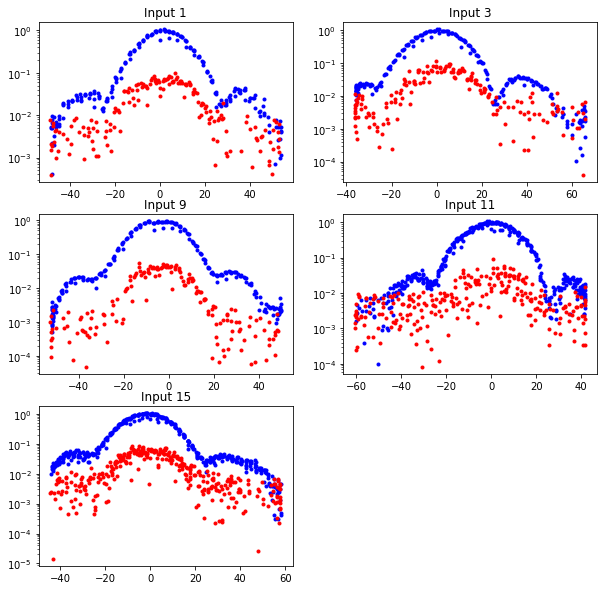

In [73]:
# Flight 618, N pol (1 is a good input)

plt.figure(1,figsize=(10,10))
for cc, chind in enumerate(N_pols):
    plt.subplot(3,2,cc+1)
    x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    # grab a slice and plot it

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice

    plt.figure(1,figsize=(10,10))
    plt.semilogy(y[ixd],z[ixd],'b.',label='copol')

    ## Let's look at that same channel, in cross-pol flight, divide by same value:

    x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    z = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # grab a slice and plot it

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')
    plt.title('Input '+str(chind))
plt.show()